In [106]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
import tqdm
import matplotlib.pyplot as plt
import util.model
from sklearn.metrics import accuracy_score
from scipy.stats import chisquare
from XMLHandler import XMLHandler
import math


def digitize(tensor, bin_edges,device, middle='true',dtype=torch.float32):
    bin_edges = torch.tensor(bin_edges,device=torch.device(device))
    # Digitize the tensor into bin indices
    bin_indices = torch.bucketize(tensor, bin_edges)

    # Calculate the corresponding middle values
    bin_indices[bin_indices >= len(bin_edges)] = len(bin_edges)-1
    bin_indices[bin_indices == -1] = 0
    middle_values = (bin_edges[bin_indices] + bin_edges[bin_indices - 1]) / 2
    return middle_values

def digitize_input(sample_list, particle, filename, dtype=torch.float32,pad_value=-20):
    xml = XMLHandler(particle, filename=filename)
    r_edge = xml.r_edges[0]
    n_theta_bin = xml.a_bins[0]
    theta_edge = np.linspace(-math.pi, math.pi, n_theta_bin)
    z_bin = len(xml.r_edges)
    z_edge = np.linspace(-0.5, z_bin - 0.5,z_bin+1)
    trans_event = []
    for event in sample_list:
        r = torch.sqrt(event[:,1]*event[:,1] + event[:,2]*event[:,2])
        theta = torch.atan(event[:,2]/event[:,1]) + torch.pi*torch.where(event[:,1]<0, torch.tensor(1, device=torch.device(device))
                                                                         , torch.tensor(0, device=torch.device(device)))
        middle_r = digitize(r,r_edge,device)
        middle_theta = digitize(theta, theta_edge,device)
        middle_z = digitize(event[:,3],z_edge,device)
        x = middle_r*torch.cos(middle_theta)
        y = middle_r*torch.sin(middle_theta)
        output_ = torch.stack((event[:,0],x,y,middle_z),dim=1)
        output_ = output_.to(dtype)

        unique_values, indices, counts = torch.unique(output_[:,1:],dim=0,return_counts=True, return_inverse=True)
        unique_values_idx = torch.arange(0, len(unique_values),device=torch.device(device))
        unique_values_gt2 = unique_values[counts>1]
        unique_values_idx_gt2 = unique_values_idx[counts>1]
        for i, combination in zip(unique_values_idx_gt2, unique_values_gt2):
            matching_indices = (indices == i).nonzero(as_tuple=False).squeeze()
            output_[matching_indices[0],0] = output_[matching_indices,0].sum()
            output_[matching_indices[1:]] = torch.ones(4,device=torch.device(device))*pad_value
        trans_event.append(output_)
    return trans_event


class attn_cls(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden, dropout):
        super().__init__()
        self.attn    = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=0)
        self.dropout = nn.Dropout(dropout)
        self.fc1     = nn.Linear(embed_dim, hidden)
        self.fc2     = nn.Linear(hidden, embed_dim)
        self.act     = nn.GELU()
    def forward(self, x, x_cls, src_key_padding_mask=None):
        x_cls = self.attn(x_cls, x, x, key_padding_mask=src_key_padding_mask)[0]
        x_cls = self.act(self.fc1(x_cls))
        x_cls = self.dropout(x_cls)
        x_cls = self.act(self.fc2(x_cls))
        return x_cls

class Classifier(nn.Module):
    def __init__(self, n_dim, embed_dim, hidden_dim, n_layers, n_layers_cls, n_heads, dropout):
        
        super().__init__()
        self.embed   = nn.Linear(n_dim, embed_dim)
        self.embed_e = nn.Sequential(util.model.GaussianFourierProjection(embed_dim=64), nn.Linear(64, 64))
        self.dense1  = util.model.Dense(64,1)
        self.encoder = nn.ModuleList(
            [
                util.model.Block(
                    embed_dim = embed_dim,
                    num_heads = n_heads,
                    hidden    = hidden_dim,
                    dropout   = dropout
                )
                for i in range(n_layers)
            ]
        )
        
        self.encoder_cls = nn.ModuleList(
            [
                attn_cls(
                    embed_dim = embed_dim,
                    num_heads = n_heads,
                    hidden    = hidden_dim,
                    dropout   = dropout
                )
            ]
        )
        
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(embed_dim, 1)
        self.cls_token  = nn.Parameter(torch.ones(1, 1, embed_dim), requires_grad=True)
        self.cls_token2 = nn.Parameter(torch.ones(1, 1, embed_dim), requires_grad=True)
        self.act = nn.GELU()
        
    def forward(self, x, e, mask=None):
        
        x = self.embed(x)
        
        embed_e_ = self.act(self.embed_e(e))
        x += self.dense1(embed_e_).clone()
        
        x_cls = self.cls_token.expand(x.size(0),1,-1)
        
        for layer in self.encoder:
            x = layer(x, x_cls=x_cls, src_key_padding_mask = mask)
            
        x_cls2 = self.cls_token2.expand(x.size(0),1,-1)
        
        for layer in self.encoder_cls:
            x_cls2 = layer(x, x_cls=x_cls2, src_key_padding_mask = mask)
            
        return torch.flatten(self.out(x_cls2))
        
class evaluate_dataset(Dataset):
    
  def __init__(self, data, inE, label, device = 'cpu'):

    self.data  = data
    self.inE   = torch.tensor(inE, device=device)
    self.label = label
    self.max_nhits = -1

  def __getitem__(self, index):
    x = self.data[index]
    y = self.inE[index]
    z = self.label[index]
    return (x,y,z)
    
  def __len__(self):
    return len(self.data)
  
  def padding(self, value = -20):

    for showers in self.data:
        if len(showers) > self.max_nhits:
            self.max_nhits = len(showers)

    padded_showers = []
    for showers in self.data:
        pad_hits = self.max_nhits-len(showers)
        padded_shower = F.pad(input = showers, pad=(0,0,0,pad_hits), mode='constant', value = value)
        padded_showers.append(padded_shower)

    self.data = padded_showers
    self.padding_value = value
    
  def digitize(self, particle='electron',xml_bin='binning_dataset_2.xml'):
    self.data = digitize_input(self.data, particle, xml_bin)

  def concat(self, dataset2):
    
    self.data.extend(dataset2.data)
    self.inE   = torch.concat((self.inE, dataset2.inE))
    self.label = torch.concat((self.label, dataset2.label))
    

class evaluator:

  def __init__(self, base_dataset_name, gen_dataset_name, padding_value = -20, device='cpu', digitize=True):
  
    base_dataset = torch.load(base_dataset_name, map_location = torch.device(device))
    gen_dataset  = torch.load(gen_dataset_name,  map_location = torch.device(device))
    dataset_size = min(len(base_dataset[0]),len(gen_dataset[0]))
    base_data    = base_dataset[0][:dataset_size]
    gen_data     = gen_dataset[0][:dataset_size]    
    if digitize:
        gen_data     = digitize_input(gen_data,'electron','binning_dataset_2.xml')
    base_inE     = base_dataset[1][:dataset_size]
    gen_inE      = gen_dataset[1][:dataset_size]
    base_label   = torch.ones(dataset_size, device=device)
    gen_label    = torch.zeros(dataset_size, device=device)
    
    self.padding_value = padding_value
    self.dataset = evaluate_dataset(base_data, base_inE, base_label, device)
    self.dataset.concat(evaluate_dataset(gen_data,  gen_inE,  gen_label,  device))
    self.dataset.padding(self.padding_value)
    self.train_dataset = None
    self.test_dataset  = None
    self.validation_dataset = None
    self.model = None
    self.device=device

  def separate_ttv(self, train_ratio, test_ratio):
    assert (train_ratio + test_ratio) < 1.0
    total_size = len(self.dataset)
    train_size = int(total_size * train_ratio)
    test_size  = int(total_size * test_ratio)
    valid_size = int(total_size - train_size - test_size)
    self.train_dataset, self.test_dataset, self.validation_dataset = torch.utils.data.random_split(self.dataset, [train_size, test_size, valid_size])

  def train(self, 
            model=None,
            batch_size=150,
            lr = 1e-4,
            jupyternotebook = False,
            mask = True,
            n_epochs = 50,
            indices = [0,1,2,3],
            device = 'cpu'):
    
    indices = torch.tensor(indices,device=device)
        
    shower_loader_train = DataLoader(self.train_dataset, batch_size = batch_size, shuffle=True)
    shower_loader_test  = DataLoader(self.test_dataset,  batch_size = batch_size, shuffle=True)
    model.to(device)
    optimiser = Adam(model.parameters(), lr=lr)
    
    av_training_acc_per_epoch = []
    av_testing_acc_per_epoch  = []
    
    fig, ax = plt.subplots(ncols=1, figsize=(4,4))

    if jupyternotebook:
        epochs = tqdm.notebook.trange(n_epochs)
        from IPython import display
        dh = display.display(fig, display_id=True)
    else:
        epochs = range(0, n_epochs)
                           
    for epoch in epochs:
                           
        cumulative_epoch_loss = 0.
        cumulative_test_epoch_loss = 0.
                
        for i, (shower_data, incident_energies, label) in enumerate(shower_loader_train, 0):
            masking = shower_data[:,:,3] == self.padding_value if mask else None
            shower_data = torch.index_select(shower_data,2,indices)
            output_vector = model(shower_data, incident_energies, mask = masking)
            criterion = torch.nn.BCEWithLogitsLoss()
            loss = criterion(output_vector, torch.flatten(label))
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            pred   = torch.round(torch.sigmoid(output_vector.detach()))
            target = torch.round(torch.flatten(label).detach())
            if i == 0:
                res_true = target
                res_pred = pred
            else:
                res_true = torch.cat((res_true, target), 0)
                res_pred = torch.cat((res_pred, pred),  0)
        
        for i, (shower_data, incident_energies, label) in enumerate(shower_loader_test,0):
            with torch.no_grad():
                masking = shower_data[:,:,3] == self.padding_value if mask else None
                shower_data = torch.index_select(shower_data, 2, indices)
                output_vector = model(shower_data, incident_energies, mask=masking)
                pred   = torch.round(torch.sigmoid(output_vector.detach()))
                target = torch.round(torch.flatten(label).detach())
                if i == 0:
                    res_true_test = target
                    res_pred_test = pred
                else:
                    res_true_test = torch.cat((res_true_test, target), 0)
                    res_pred_test = torch.cat((res_pred_test, pred),  0)
                    
        acc_train = accuracy_score(res_true.cpu(), res_pred.cpu())
        acc_test  = accuracy_score(res_true_test.cpu(), res_pred_test.cpu())
        av_training_acc_per_epoch.append(acc_train)
        av_testing_acc_per_epoch.append(acc_test)
        
        if jupyternotebook:
            epochs.set_description('Accuracy: {:2f}(Train) {:2f}(Test)'.format(acc_train,acc_test))

            fig, ax = plt.subplots(ncols=1, figsize=(4,4))
            plt.title('')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.yscale('log')
            plt.plot(av_training_acc_per_epoch, label='training')
            plt.plot(av_testing_acc_per_epoch, label='testing')
            plt.legend(loc='lower right')
            dh.update(fig)
            plt.close(fig)
    self.model = model
    return model
  def evulate_score(self, 
                    model=None, 
                    indices = [0,1,2,3],
                    batch_size = 150,
                    mask = True):
    if model is None:
        model = self.model
    indices = torch.tensor(indices,device=self.device)    
    shower_loader_validation = DataLoader(self.validation_dataset, batch_size = batch_size, shuffle=True)
    for i, (shower_data, incident_energies, label) in enumerate(shower_loader_validation,0):
        with torch.no_grad():
            masking = shower_data[:,:,3] == self.padding_value if mask else None
            shower_data = torch.index_select(shower_data, 2, indices)
            output_vector = model(shower_data, incident_energies, mask=masking)
            pred   = torch.round(torch.sigmoid(output_vector.detach()))
            target = torch.round(torch.flatten(label).detach())
            if i == 0:
                res_true_valid = target
                res_pred_valid = pred
            else:
                res_true_valid = torch.cat((res_true_valid, target), 0)
                res_pred_valid = torch.cat((res_pred_valid, pred),  0)
                    
    return (accuracy_score(res_true_valid.cpu(), res_pred_valid.cpu()))
            
  def draw_distribution(self):
    
    e_geant4 = []
    e_gen    = []
    x_geant4 = []
    x_gen    = []
    y_geant4 = []
    y_gen    = []
    z_geant4 = []
    z_gen    = []
    
    nEntries_geant4 = []
    nEntries_gen    = []
    
    point_clouds_loader = DataLoader(self.dataset, batch_size = 150)    
    for i, (shower_data, incident_energies, label) in enumerate(point_clouds_loader, 0):
    
        valid_event = []
        data_np = shower_data.cpu().numpy().copy()
        label_np = label.cpu().numpy().copy()
        
        mask = ~(data_np[:,:,3] == self.padding_value)
        
        for j in range(len(data_np)):
            valid_event = data_np[j][mask[j]]
            if label_np[j] == 0:
                e_gen += ((valid_event).copy()[:,0]).flatten().tolist()
                x_gen += ((valid_event).copy()[:,1]).flatten().tolist()
                y_gen += ((valid_event).copy()[:,2]).flatten().tolist()
                z_gen += ((valid_event).copy()[:,3]).flatten().tolist()
                nEntries_gen.append(len(valid_event))
            else:
                e_geant4 += ((valid_event).copy()[:,0]).flatten().tolist()
                x_geant4 += ((valid_event).copy()[:,1]).flatten().tolist()
                y_geant4 += ((valid_event).copy()[:,2]).flatten().tolist()
                z_geant4 += ((valid_event).copy()[:,3]).flatten().tolist()
                nEntries_geant4.append(len(valid_event))
                
    fig, ax = plt.subplots(2,3, figsize=(15,10))
    self.get_plot(ax[0][0], "# entries", "Hit entries", nEntries_geant4, nEntries_gen, np.arange(min(nEntries_geant4),max(nEntries_geant4),1))
    self.get_plot(ax[0][1], "# entries", "Hit energies", e_geant4, e_gen, np.arange(min(e_geant4),max(e_geant4),(max(e_geant4)-min(e_geant4))/100.))
    self.get_plot(ax[0][2], "# entries", "x", x_geant4, x_gen, np.arange(min(x_geant4),max(x_geant4),0.1))
    self.get_plot(ax[1][0], "# entries", "y", y_geant4, y_gen, np.arange(min(y_geant4),max(y_geant4),0.1))
    self.get_plot(ax[1][1], "# entries", "z", z_geant4, z_gen, np.arange(min(z_geant4),max(z_geant4),0.1))
    print(x_gen)
    
  def get_plot(self, ax, y_label, x_label, x_geant4, x_gen, bins):
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    x_geant4_binned,_ = np.histogram(x_geant4, bins=bins)
    x_gen_binned,_    = np.histogram(x_gen,    bins=bins)
    #chi2 = ((x_geant4_binned - x_gen_binned)**2/(x_geant4_binned)).sum()/len(x_gen_binned)
    ax.hist(x_gen, bins = bins, label="gen", alpha=0.5)
    ax.hist(x_geant4, bins = bins, label="geant4", alpha=0.5)
    ax.legend(loc='upper right')
    
    
        
        

In [107]:
device = 'cuda'
evaluator1 = evaluator(base_dataset_name = "samples/dataset_2_tensor_padding_euclidian_nentry1129To1269.pt",
                       gen_dataset_name   = "sampling/embed64_hid128_6trans_4head_dropout0_mask/sample.pt",
                       device = device, digitize=False)

/tmp/ipykernel_408/2911412837.py:134: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



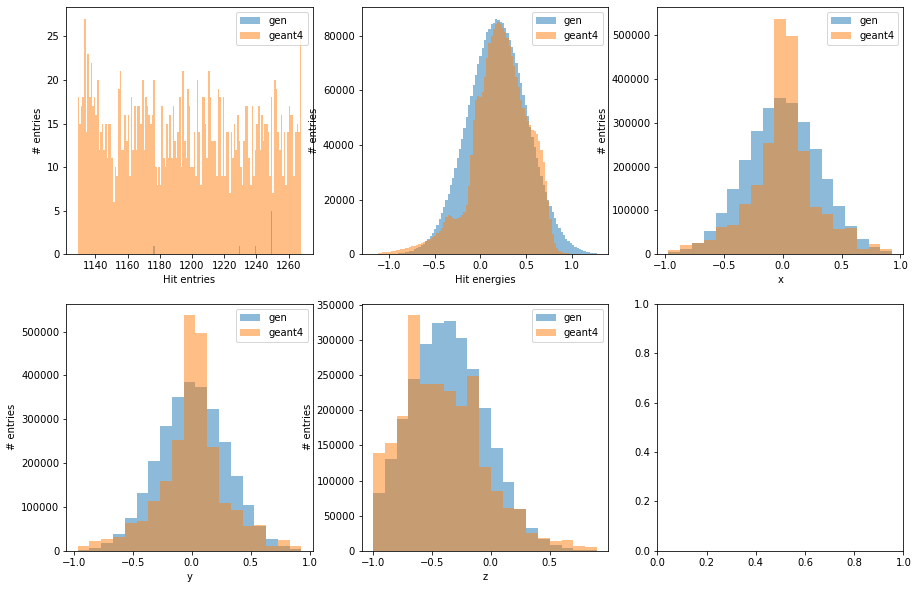

In [104]:
evaluator1.draw_distribution()

Initial GaussianFourierProjection W weights: Parameter containing:
tensor([ 54.5532, -38.6373,   5.9257,  -8.6567,  -1.1984,   3.4023, -24.2345,
        -37.0236,   5.8633,  12.7411,  46.1230, -28.6379,  34.4674, -22.8960,
        -25.1299,  22.0952,  12.8182,  -0.1433,  29.1591,  27.6247,  11.9317,
         22.5769, -59.4740,  -9.2448,  23.0258, -19.1592,  -0.1704,  -3.3368,
         18.0013,  -7.1055,  -5.2557,  -4.7524])
Initial Dense weights: Parameter containing:
tensor([[ 0.0945, -0.1087, -0.0307, -0.0911,  0.0805,  0.1138, -0.0940,  0.0368,
          0.0978,  0.1165, -0.0473, -0.0556, -0.0360, -0.1029,  0.0994, -0.0660,
          0.1121,  0.1084,  0.0646, -0.0050,  0.1247,  0.0630, -0.1237, -0.0670,
         -0.0910, -0.1046,  0.0553, -0.0672,  0.0669,  0.0983,  0.0683,  0.0924,
         -0.1068, -0.0484,  0.0549,  0.0965, -0.0118,  0.0364, -0.0394,  0.0737,
         -0.0483, -0.0629, -0.0178, -0.0999, -0.0051, -0.1115,  0.0332,  0.1023,
          0.0629, -0.0771,  0.1081, -0.06

  0%|          | 0/150 [00:00<?, ?it/s]

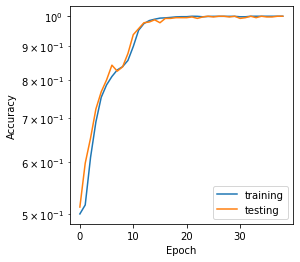

KeyboardInterrupt: 

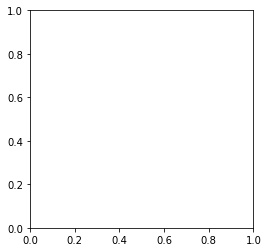

In [105]:
indices = [0,1,2,3] # 0: e, 1: x, 2: y, 3:z (choose parameters set used for training)
model = Classifier(n_dim=len(indices),
                   embed_dim=64,
                   hidden_dim=64,
                   n_layers=2,
                   n_layers_cls=2,
                   n_heads=2,
                   dropout=0)

evaluator1.separate_ttv(0.8,0.1)
evaluator1.train( 
            model=model,
            jupyternotebook = True,
            mask = True,
            n_epochs = 150,
            device = device,
            indices = indices)
print('score', evaluator1.evulate_score(
                    model   = model, 
                    indices = indices))